# Edgeworth Model Options Pricing Model

The creation of new option pricing models that directly incorporate time varying volatility and non-normal distributions is not an easy process and the results are quite complex and “messy”.  One “relatively easy” way to take the normal assumption out of the binomial lattice model and insert a distribution assumption that allows for skewness and kurtosis is known as the Edgeworth binomial lattice model.  The following process describes the adjustments that are necessary.

For $j=0,1,2, \ldots, n$ periods in the binomial lattice, then the value of a random variable is $x_j=(2 * j-n) / \sqrt{n}$
with associated binomial probabilities $b\left(x_j\right)=\frac{n !}{j ! *(n-j) !}^*{ }^{0.5^n}$

The Edgeworth expansion for non-normal skewness and kurtosis creates a new set of probabilities (based actually on the Gram-Charlier expansion)
$$
f\left(x_j\right)=b\left(x_j\right) *\left[1+\frac{\text { skew }}{6} *\left(x_j^3-3 x_j\right)+\frac{\text { kurtosis }}{24} *\left(x_j^4-6 x_j^2+3\right)\right]
$$
which are rescaled as $f\left(x_j\right)=f\left(x_j\right) / \sum_{j=0}^n f\left(x_j\right)$

Then a standardized random variable from this distribution takes on values
$$
x_j=\left[x_j-\sum_{j=0}^n\left(f\left(x_j\right)^* x_j\right)\right] / \sqrt{\sum_{j=0}^n\left(f\left(x_j\right) *\left(x_j-\sum_{j=0}^n\left(f\left(x_j\right)^* x_j\right)\right)^2\right)}
$$
which when applied to a stock price under risk neutrality yields stock prices
$$
S_j=S_d * e^a
$$
where $\alpha=(r-q) t-\ln \left[\sum_{j=0}^n\left(f\left(x_j\right)^* e^{\sigma \sqrt{t} x_j}\right)\right]+\sigma \sqrt{t} x_j$
and $S_d=S-\sum D_i{ }^* e^{-r i t}$, the current stock price less the present value of all future discrete dividends expected to be paid during the life of the option.

Then European call and put values are simply
$$
\begin{aligned}
&C_e=\left[\sum_{j=0}^n\left(f\left(x_j\right)^* \max \left(0, S_j-K\right)\right)\right]^* e^{-n} \\
&P_e=\left[\sum_{j=0}^n\left(f\left(x_j\right)^* \max \left(0, K-S_j\right)\right)\right]^* e^{-r t}
\end{aligned}
$$

For American call and put values, beginning at the end of the lattice there are path probabilities
$$
P_j=f\left(x_j\right) / \frac{n !}{j !^*(n-j) !}
$$
and one-period back are the path probabilities
$$
P_{n-1, j}=P_j+P_{j+1}
$$
and move probabilities p and (1-p)
$$
\begin{aligned}
&p_{n-1, j}=P_{j+1} / P_{n-1, j} \\
&\left(1-p_{n-1, j}\right)=P_j / P_{n-1, j}
\end{aligned}
$$
so that the stock prices one-period back are equal to
$$
S_{n-1, j}=\left[p_{n-1, j} * S_{j+1}+\left(1-p_{n-1, j}\right) * S_j\right]^* e^{-(r-q), / n}
$$

With $\sum D_i e^{-\not t t_i}$ equal to the present value of all future discrete dividends as of the time node equal to (n-1), then the call and put values at the time node equal to $(\mathrm{n}-1)$ are
$$
\text { Call }_{n-1, j}=\max \left\{S_{n-1, j}+\sum D_i e^{-n n_i}-K,\left[p_{n-1, j} * \text { Call }_{j+1}+\left(1-p_{n-1, j}\right) *{ }^* \text { Call }_j\right] e^{-r / n}\right\}
$$
$$
P_u t_{n-1, j}=\max \left\{K-\left(S_{n-1, j}+\sum D_i e^{-n t_i}\right),\left[p_{n-1, j} * P u t_{j+1}+\left(1-p_{n-1, j}\right)^* P u t_j\right]^* e^{-r t / n}\right\}
$$

Then move recursively back through the lattice in the same manner, from the next period back path probabilities, move probabilities, stock prices, and option values, to eventually arrive at the start of the lattice and the current option values (and current stock price).
I told you it was only "relatively easy"!

In [8]:
import numpy as np
import pandas as pd

In [9]:
def choose(n, x):
    P = np.array([np.array([0.0]*(n + 1), dtype=np.double)]*(n + 1), dtype=np.double)
    P[0, :] = 1.0
    P += np.eye((n + 1), (n + 1), dtype=np.double)

    j = 2
    while j <= n:
        i = 1
        while i <= j-1:
            P[i][j] = P[i-1][j-1] + P[i][j-1]
            i += 1
        j += 1
   
    return P[x][n]

In [10]:
def sumvec(v):
    # return the sum of v
    return np.sum(v)

In [11]:
def edgeworth_binomial_tree(Spot, K, r, T, v, skew, kurt, n):

    dt = T/n

    SmallP = np.array([np.array([0.0] * (n + 1), dtype=np.double)] * (n + 1), dtype=np.double)
    BigP = np.array([np.array([0.0] * (n + 1), dtype=np.double)] * (n + 1), dtype=np.double)
    S = np.array([np.array([0.0] * (n + 1), dtype=np.double)] * (n + 1), dtype=np.double)
    EC = np.array([np.array([0.0] * (n + 1), dtype=np.double)] * (n + 1), dtype=np.double)
    EP = np.array([np.array([0.0] * (n + 1), dtype=np.double)] * (n + 1), dtype=np.double)
    AC = np.array([np.array([0.0] * (n + 1), dtype=np.double)] * (n + 1), dtype=np.double)
    AP = np.array([np.array([0.0] * (n + 1), dtype=np.double)] * (n + 1), dtype=np.double)

    y = (2 * np.arange(n + 1) - n) / np.sqrt(n)
    c = np.array([choose(n, j) for j in np.arange(n + 1, dtype=np.int8)])
    b = np.multiply(c, np.power(0.5, n))
    f = (1 + (1 / 6.0) * skew * (np.power(y, 3) - 3 * y) +
	        (1 / 24.0) * (kurt - 3) * (np.power(y, 4) - 6 * np.power(y, 2) + 3) +
			      (1 / 72.0) * np.power(skew, 2) * (np.power(y, 5) - 10 * np.power(y, 3) + 15 * y))*b

    P = f / sumvec(f)
    SmallP[:, n] = P / c
    BigP[:, n] = SmallP[:, n]
    Mean = np.multiply(P, y)

    M = sumvec(Mean)
    PyM = P * np.power(y-M, 2)

    V2 = sumvec(PyM)
    x = (y - M) / np.sqrt(V2)
    Pe = P*np.exp(v*np.sqrt(T)*x)

    mu = r - (1.0/T)*np.log(sumvec(Pe))
    S[:, n] = Spot*np.exp(mu*T + v*np.sqrt(T)*x)

    j = n-1
    while j >= 0:
        i = 0
        while i <= j:
            BigP[i][j] = BigP[i][j+1] + BigP[i+1][j+1]
            SmallP[i][j] = BigP[i][j+1] / BigP[i][j]
            S[i][j] = (SmallP[i][j] * S[i][j+1] + (1.0 - SmallP[i][j]) * S[i+1][j+1]) * np.exp(-r * dt)
            i += 1
        j -= 1

    # Compute terminal payoffs
    EC[:, n] = np.maximum(S[:, n] - K, 0.0)
    AC[:, n] = np.maximum(S[:, n] - K, 0.0)
    EP[:, n] = np.maximum(K - S[:, n], 0.0)
    AP[:, n] = np.maximum(K - S[:, n], 0.0)

    # Backward recursion through the tree
    j = n-1
    while j >= 0:
        i = 0
        while i <= j:
            Pr = SmallP[i][j]
            EC[i][j] = np.exp(-r * dt) * (Pr * (EC[i][j+1]) + (1-Pr) * (EC[i+1][j+1]))
            EP[i][j] = np.exp(-r * dt) * (Pr * (EP[i][j+1]) + (1-Pr) * (EP[i+1][j+1]))
            AC[i][j] = max(S[i][j] - K, np.exp(-r * dt) * (Pr * (AC[i][j+1]) + (1 - Pr) * (AC[i+1][j+1])))
            AP[i][j] = max(K - S[i][j], np.exp(-r * dt) * (Pr * (AP[i][j+1]) + (1 - Pr) * (AP[i+1][j+1])))
            i += 1
        j -= 1
    
    return EC, AC, EP, AP

In [12]:
def edgeworth_european_call(S, K, r, T, v, skew, kurt, n):
    EC, _, _, _ = edgeworth_binomial_tree(S, K, r, T, v, skew, kurt, n)
    return EC[0][0]


def edgeworth_american_call(S, K, r, T, v, skew, kurt, n):
    _, AC, _, _ = edgeworth_binomial_tree(S, K, r, T, v, skew, kurt, n)
    return AC[0][0]


def edgeworth_european_put(S, K, r, T, v, skew, kurt, n):
    _, _, EP, _ = edgeworth_binomial_tree(S, K, r, T, v, skew, kurt, n)
    return EP[0][0]


def edgeworth_american_put(S, K, r, T, v, skew, kurt, n):
    _, _, _, AP = edgeworth_binomial_tree(S, K, r, T, v, skew, kurt, n)
    return AP[0][0]


Price an example set of options.

In [13]:
S = 30.0  # S price
K = 25.0  # Strike price
r = 0.05 # Interest rate
T = 0.5  # Maturity
v = 0.3  # Volatility
skew = 1.0  # Skewness
kurt = 3.0  # Kurtosis
n = int(100.0)  # Number of time steps

ec = edgeworth_european_call(S, K, r, T, v, skew, kurt, n)
ac = edgeworth_american_call(S, K, r, T, v, skew, kurt, n)
ep = edgeworth_european_put(S, K, r, T, v, skew, kurt, n)
ap = edgeworth_american_put(S, K, r, T, v, skew, kurt, n)

print(f"The price of a European Call is {ec}")
print(f"The price of a American Call is {ac}")
print(f"The price of a European Put  is {ep}")
print(f"The price of a American Put  is {ap}")

The price of a European Call is 6.001063190311885
The price of a American Call is 6.044359179586465
The price of a European Put  is 0.3838109910201844
The price of a American Put  is 0.39060306423802765


Plot the relationship between skew and the price of a european call option.

In [23]:
prices = []
skews = [i / 10 for i in range(1, 31)]

for skew in skews:
    ec = edgeworth_european_call(S, K, r, T, v, skew, kurt, n)
    prices.append(ec)

<AxesSubplot:>

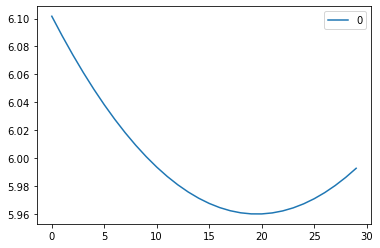

In [24]:
pd.DataFrame(prices).plot()